In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from openretina.utils.h5_handling import (
    load_dataset_from_h5,
    print_h5_structure,
)
from openretina.utils.misc import CustomPrettyPrinter

%load_ext autoreload
%autoreload 2

In [2]:
# base_folder = Path("~/PhD_data").expanduser()
base_folder = Path("/Data/")

In [3]:
pp = CustomPrettyPrinter(indent=4)

In [4]:
!ls /Data/baccus_data/neural_code_data/ganglion_cell_data/

15-10-07  15-11-21a  15-11-21b


In [5]:
baccus_data_example_path = os.path.join(
    base_folder,
    "baccus_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5",
)

In [6]:
print_h5_structure(baccus_data_example_path)

{'spikes': {'cell01': 'h5.Dataset(shape=(43927,)), float64',
            'cell02': 'h5.Dataset(shape=(11819,)), float64',
            'cell03': 'h5.Dataset(shape=(12423,)), float64',
            'cell04': 'h5.Dataset(shape=(37662,)), float64',
            'cell05': 'h5.Dataset(shape=(10976,)), float64',
            'cell06': 'h5.Dataset(shape=(11654,)), float64',
            'cell07': 'h5.Dataset(shape=(17792,)), float64',
            'cell08': 'h5.Dataset(shape=(4566,)), float64',
            'cell09': 'h5.Dataset(shape=(36307,)), float64'},
 'test': {'repeats': {'cell01': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell02': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell03': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell04': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell05': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell06': 'h5.Dataset(shape=(5, 5997)), float64',
                   

In [7]:
train_video_baccus = load_dataset_from_h5(baccus_data_example_path, "/train/stimulus")
test_video_baccus = load_dataset_from_h5(baccus_data_example_path, "/test/stimulus")

In [8]:
baccus_data_example_path_2 = os.path.join(
    base_folder,
    "baccus_data/neural_code_data/ganglion_cell_data/15-11-21b/naturalscene.h5",
)
train_video_baccus_2 = load_dataset_from_h5(baccus_data_example_path_2, "/train/stimulus")
test_video_baccus_2 = load_dataset_from_h5(baccus_data_example_path_2, "/test/stimulus")

In [9]:
train_video_baccus = train_video_baccus[None, :]
train_video_baccus.shape

(1, 359802, 50, 50)

Regarding the stimuli used:

    A video monitor projected the visual stimuli at 30 Hz controlled by Matlab (Mathworks), using Psychophysics Toolbox.54 Stimuli had a constant mean intensity of 10 mW/m2. Images were presented in a 50 x 50 grid with a square size of 50 mm. Static natural jittered scenes consisted of images drawn from a natural image database.55 To create images for presentation to the retina, original color images were converted to grayscale, and were scaled to have minimum and maximum pixel intensities that matched that of the monitor. Pixel regions of 50 x 50 size were then selected from each image at a random location without spatial averaging for presentation.
    
So it is natural images, not videos. Also, regarding stimulus presentation:

    The image also abruptly changed in a single frame to a different location every one second, representing saccades, although such transitions did not contain a sweeping shift in the image. Transitions occurred both between different locations in the same image and between different images.

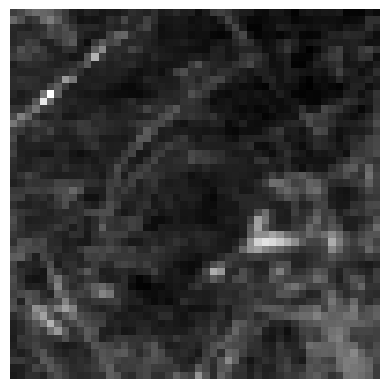

In [10]:
from openretina.plotting import play_stimulus

play_stimulus(torch.Tensor(train_video_baccus[:, :90]))

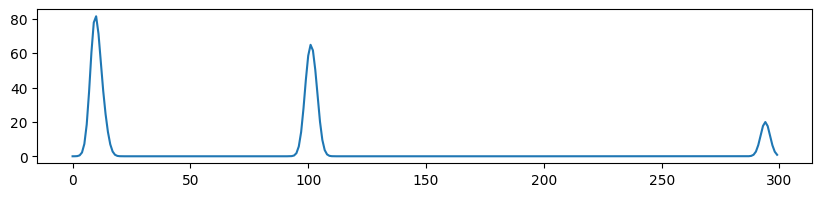

In [11]:
train_response_baccus = load_dataset_from_h5(baccus_data_example_path, "/train/response/firing_rate_20ms")
test_response_baccus = load_dataset_from_h5(baccus_data_example_path, "/test/response/firing_rate_20ms")
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plt.plot(train_response_baccus[8, :300])

Single "clip" length is 90 frames. (i.e. how long an image was shown for)

Response should be firing rate in Hz, calculated from the ephys trace with various time bins. In the paper they say to train the model "The response and stimulus were binned in 10 ms time bins."

Our response is also a firing rate, but inferred from the calcium trace using c2s. Given that they are using MEAs, the temporal resolution of the signal (and some of the binning they used) is much higher. 

However, we can still use the spikes they provided to get a similar binning to our data.

---

# Test resampling

In [46]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

Salamander data has 30 KHz sampling rate with MEAs, whereas we have ~7.8 Hz with Ca2+ imaging.

They take 10 or 20 ms bins (100 or 50 Hz) and than have to *downsample* this to match the 30 Hz movie framerate.

We effectively take 128 ms bins (given our 7.8125 Hz imaging speed) and then have to *upsample* it to match the 30 Hz movie framerate.

In [7]:
print_h5_structure(baccus_data_example_path)

{'spikes': {'cell01': 'h5.Dataset(shape=(43927,)), float64',
            'cell02': 'h5.Dataset(shape=(11819,)), float64',
            'cell03': 'h5.Dataset(shape=(12423,)), float64',
            'cell04': 'h5.Dataset(shape=(37662,)), float64',
            'cell05': 'h5.Dataset(shape=(10976,)), float64',
            'cell06': 'h5.Dataset(shape=(11654,)), float64',
            'cell07': 'h5.Dataset(shape=(17792,)), float64',
            'cell08': 'h5.Dataset(shape=(4566,)), float64',
            'cell09': 'h5.Dataset(shape=(36307,)), float64'},
 'test': {'repeats': {'cell01': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell02': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell03': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell04': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell05': 'h5.Dataset(shape=(5, 5997)), float64',
                      'cell06': 'h5.Dataset(shape=(5, 5997)), float64',
                   

In [109]:
sample_spike_times = load_dataset_from_h5(baccus_data_example_path, "/spikes/cell01")

In [ ]:
bin_len = 0.128
hist, bin_edges = np.histogram(sample_spike_times, bins=np.arange(0, sample_spike_times[-1], bin_len))

(0.0, 10.0)

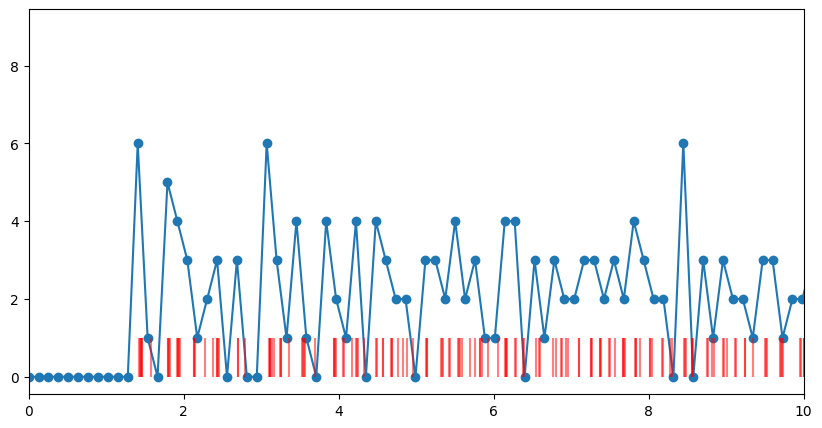

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(bin_edges[:-1], hist, marker="o")
plt.vlines(sample_spike_times, 0, 1, color="r", alpha=0.5)
plt.xlim(0, 10)

In [112]:
interpolated_hist = interp1d(bin_edges[:-1], hist, kind="linear", bounds_error=False, fill_value="extrapolate")(
    np.arange(0, sample_spike_times[-1], 1 / 30)
)
interpolated_hist_corrected = interpolated_hist / interpolated_hist.std()

(0.0, 300.0)

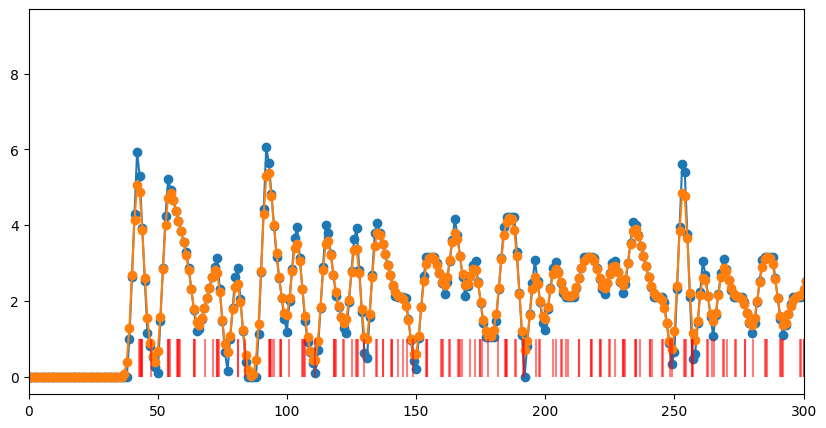

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(interpolated_hist_corrected, marker="o")

plt.plot(gaussian_filter1d(interpolated_hist_corrected, sigma=1), marker="o")
plt.vlines(sample_spike_times * 30, 0, 1, color="r", alpha=0.5)
plt.xlim(0, 10 * 30)